# 1. Обзор данных

## Данные

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Данные за 2016 год могут быть неполными.

## Задача

На основе исторических данных о продажах компьютерных игр необходимо выявить закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании в следующем году.


In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [2]:
games = pd.read_csv('4_games.csv')
display(games.sample(10))
print(games.info())
print('\nПропущенные значения:')
print(games.isna().sum())
display(games.describe())
print('\nДубликаты:', games.duplicated().sum())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
968,Mafia III,PS4,2016.0,Action,0.42,1.08,0.03,0.28,68.0,5.1,M
1691,Captain Toad: Treasure Tracker,WiiU,2014.0,Puzzle,0.53,0.38,0.19,0.09,81.0,8.6,E
8963,Dance Dance Revolution (North America),PS,2001.0,Simulation,0.08,0.06,0.00,0.01,NaN,NaN,NaN
13848,Famicom Mini: Clu Clu Land,GBA,2004.0,Puzzle,0.00,0.00,0.04,0.00,NaN,NaN,NaN
16110,Valentino Rossi: The Game,PC,2016.0,Racing,0.00,0.01,0.00,0.00,72.0,6.2,E
8119,Aliens: Colonial Marines,PC,2013.0,Shooter,0.10,0.06,0.00,0.02,45.0,3.5,M
7649,Teenage Mutant Ninja Turtles 3: Mutant Nightmare,PS2,2005.0,Action,0.10,0.08,0.00,0.03,53.0,7,E10+
9157,Dream Pinball 3D,Wii,2008.0,Misc,0.10,0.02,0.00,0.01,54.0,7.6,E10+
6201,Medieval Moves: Deadmund's Quest,PS3,2011.0,Action,0.13,0.11,0.00,0.04,61.0,6.5,E10+
2699,That's So Raven,GBA,2004.0,Adventure,0.54,0.20,0.00,0.01,39.0,7.6,E


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None

Пропущенные значения:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       85

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000



Дубликаты: 0


## Обзор данных. Вывод


Всего в базе 16715 записей с информацией о рейтингах и продажах компьютерных игр с 1980 по 2016гг.

**Проблемы с типами данных:**

* Год выпуска Year_of_Release может быть int.
* Оценка пользователей User_Score должна быть float, а не object. В поле попадаются нечисловые значения.

**Пропуски:**

* В названии игры Name пропущено 2 значения. Посмотрим на записи и решим, что с ними делать.
* Год выпуска Year_of_Release пропущен 269 раз. Заменим пропуски на 0, чтобы привести поле к целочисленному типу.
* Оценка критиков Critic_Score отсутствует по 8578 играм (почти половина).
* Оценка пользователей User_Score отсутствует по 6701 играм.
* Рейтинг от организации ESRB Rating не проставлен по 6766 играм.

**Другое:**

Нужно привести названия столбцов к нижнему регистру.

# 2. Предобработка данных 

In [3]:
#  Приведем название стобцов к нижнему регистру
games.columns = games.columns.str.lower()
print(games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


In [4]:
# Изменим тип данных поля 'year_of_release' на int:
games['year_of_release'] = games['year_of_release'].fillna(0).astype('int')
games.info()
display(games.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
4771,Metal Gear Solid: The Legacy Collection,PS3,2013,Adventure,0.31,0.01,0.03,0.06,93.0,9,M
6675,NBA Courtside 2 featuring Kobe Bryant,N64,1999,Sports,0.20,0.05,0.00,0.00,NaN,NaN,NaN
10930,Rygar: The Battle of Argus,Wii,2008,Action,0.09,0.00,0.00,0.01,52.0,7,T
7844,SSX Tricky,GBA,2002,Sports,0.14,0.05,0.00,0.00,66.0,tbd,E
13456,The Bible Game,XB,2005,Misc,0.03,0.01,0.00,0.00,60.0,2.7,E


In [5]:
# Разберёмся с нечисловыми значениями в поле 'user_score':
print(games['user_score'].unique()) # кроме NaN, попадаются ещё 'tbd' (To Be Determined) - по сути те же NaN
# Заменим значения 'tbd' на NaN:
games.loc[games['user_score']== 'tbd', 'user_score'] = np.nan
# Теперь изменим тип данных поля 'user_score' на float:
games['user_score'] = games['user_score'].astype('float32') 
display(games.sample(5))

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13305,Need for Speed Carbon,PC,2006,Racing,0.00,0.04,0.00,0.01,78.0,7.2,E10+
13013,Aliens in the Attic,DS,2009,Action,0.05,0.00,0.00,0.00,58.0,6.0,E10+
8908,Capcom Classics Collection,XB,2005,Misc,0.11,0.03,0.00,0.01,81.0,NaN,T
2312,LEGO Pirates of the Caribbean: The Video Game,DS,2011,Action,0.34,0.46,0.00,0.10,69.0,NaN,E10+
1402,Paper Mario,N64,2000,Role-Playing,0.58,0.18,0.59,0.02,NaN,NaN,NaN


In [6]:
# Рассмотрим пропуски в поле 'name':
display(games[games['name'].isna()])
# Пропущен жанр и все оценки, такие записи нам не пригодятся удалим их:
games = games.dropna(subset=['name'])
display(games[games['name'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [7]:
# Посмотрим на пропуски в рейтингах:
games_year = (games.groupby('year_of_release')
              .agg(
                  count = ('genre', 'count'),
                  critic_score = ('critic_score','count'),
                  user_score = ('user_score','count'),
                  rating= ('rating','count')
              ).reset_index()
              )
games_year['critic_score'] = games_year['critic_score'] / games_year['count']
games_year['user_score'] = games_year['user_score'] / games_year['count']
games_year['rating'] = games_year['rating'] / games_year['count']
print('Доля ненулевых значений по годам:')
display(games_year)

Доля ненулевых значений по годам:


,year_of_release,count,critic_score,user_score,rating
0,0,269,0.572491,0.472119,0.672862
1,1980,9,0.000000,0.000000,0.000000
2,1981,46,0.000000,0.000000,0.000000
3,1982,36,0.000000,0.000000,0.000000
4,1983,17,0.000000,0.000000,0.000000
5,1984,14,0.000000,0.000000,0.000000
6,1985,14,0.071429,0.071429,0.071429
7,1986,21,0.000000,0.000000,0.000000
8,1987,16,0.000000,0.000000,0.000000
9,1988,15,0.066667,0.066667,0.066667


Видимо, оценки критиков и пользователей стали активно собираться только с 1996 года.

In [8]:
# Добавим в таблицу поле с суммой продаж по всем регионам:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
display(games.sample(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
13181,Shinseiki Evangelion 2: Tsukurareshi Sekai - A...,PSP,2006,Adventure,0.00,0.00,0.05,0.00,NaN,NaN,NaN,0.05
14897,Senran Kagura: Bon Appétit!,PSV,2014,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03
829,Madden NFL 15,X360,2014,Sports,1.77,0.06,0.00,0.22,NaN,5.5,E,2.05
801,Tetris Worlds,PS2,2002,Puzzle,1.11,0.71,0.00,0.27,44.0,6.2,E,2.09
3605,Gravity Rush,PSV,2012,Action,0.21,0.17,0.09,0.08,83.0,8.5,T,0.55


Заполним, где это возможно, пропуски в рейтингах critic_score и user_score на основе оценок той же игры, но на других платформах.

In [9]:
# Возьмём для проверки одну из мультиплатформенных игр. Например:
display(games[games['name']=='007: Quantum of Solace']) 
# На PS2 нет обеих оценок, на DS нет оценки пользователей и на PS2 нет рейтинга ESRB

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1285,007: Quantum of Solace,X360,2008,Action,0.82,0.51,0.01,0.14,65.0,7.1,T,1.48
1785,007: Quantum of Solace,PS3,2008,Action,0.43,0.51,0.02,0.19,65.0,6.6,T,1.15
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54.0,7.5,T,0.65
4475,007: Quantum of Solace,PS2,2008,Action,0.17,0.00,0.00,0.26,NaN,NaN,NaN,0.43
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65.0,NaN,T,0.13
14658,007: Quantum of Solace,PC,2008,Action,0.01,0.01,0.00,0.00,70.0,6.3,T,0.02


In [10]:
#Заполним по возможности пропуски в 'critic_score':
print('Пропусков в critic_score до заполнения:', games['critic_score'].isna().sum())

games['critic_score'] = games['critic_score'].fillna(games.groupby('name')['critic_score'].transform('median'))

print('Пропусков в critic_score после заполнения:', games['critic_score'].isna().sum())

Пропусков в critic_score до заполнения: 8576
Пропусков в critic_score после заполнения: 7615


In [11]:
#Заполним по возможности пропуски в 'user_score':
print('Пропусков в user_score до заполнения:', games['user_score'].isna().sum())

games['user_score'] = games['user_score'].fillna(games.groupby('name')['user_score'].transform('median'))

print('Пропусков в user_score после заполнения:', games['user_score'].isna().sum())

Пропусков в user_score до заполнения: 9123
Пропусков в user_score после заполнения: 8024


Заполним по возможности пропуски в рейтинге ESRB rating.

In [12]:
# Составим словарь с названием игры и рейтингом от организации ESRB:
esrb_df = games[['name', 'rating']]
esrb_df.dropna(subset=['rating'], inplace=True)
esrb_df.sort_values(by='name', inplace=True)
esrb_df = esrb_df.drop_duplicates(subset='name')

display(esrb_df)

,name,rating
2454,Tales of Xillia 2,T
1561,.hack//Infection Part 1,T
2990,.hack//Mutation Part 2,T
4265,.hack//Outbreak Part 3,T
3757,007 Racing,T
...,...,...
10843,thinkSMART,E
14453,thinkSMART FAMILY!,E
16494,thinkSMART: Chess for Kids,E
645,uDraw Studio,E


В словаре содержатся только те игры, по которым проставлен рейтинг хотя бы на одной из платформ.

In [13]:
print('Пропусков в rating до заполнения:', games['rating'].isna().sum())

games = games.merge(esrb_df, on='name', how='left')

# Удалим, чтобы не путаться прежнее поле с рейтингом, а новое переименуем:
games.drop(['rating_x'], axis='columns', inplace=True)
games.rename(columns={'rating_y':'rating'}, inplace=True)

print('Пропусков в rating после заполнения:', games['rating'].isna().sum())
display(games)

Пропусков в rating до заполнения: 6764
Пропусков в rating после заполнения: 6327


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,82.54,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,40.24,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,35.52,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,32.77,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,31.38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,0.01,NaN
16709,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,0.01,NaN
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,0.01,NaN
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,0.01,NaN


In [14]:
# Заполним оставшиеся в 'rating' пропуски значением 'no info':
print('Пропусков в rating до заполнения:', games['rating'].isna().sum())

games['rating'] = games['rating'].fillna('no info') 

print('Пропусков в rating после заполнения:', games['rating'].isna().sum())
display(games.sample(5))

Пропусков в rating до заполнения: 6327
Пропусков в rating после заполнения: 0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales,rating
12114,Warhammer: Battle For Atluma,PSP,2006,Action,0.06,0.00,0.00,0.01,55.0,7.4,0.07,T
8376,Gunvalkyrie,XB,2002,Shooter,0.13,0.04,0.00,0.01,73.0,7.3,0.18,T
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,7.98,no info
14898,My Ballet Studio,Wii,2009,Simulation,0.02,0.00,0.00,0.00,NaN,NaN,0.02,E
7544,From TV Animation One Piece: Grand Battle! 3,GC,2003,Fighting,0.00,0.00,0.20,0.01,NaN,NaN,0.21,no info


## Предобработка данных. Вывод.

**Приведение типов данных:**

* Год выпуска Year_of_Release привели к int.
* Оценку пользователей User_Score привели к float. Значения "tbd" (to be determined) заменили на NaN.

**Пропуски:**

* В названии игры Name пропущено 2 значения. Так же в этих записях пропущен жанр и все рейтинги. Год выпуска 1993. Эти записи нам не понадобятся для решения поставленной задачи. Удалили их.
* Год выпуска Year_of_Release пропущен 269 раз. Заменили пропуски на 0, чтобы привести поле к целочисленному типу и сэкономить память.
* Пропуски в Оценке критиков Critic_Score и Оценке пользователей User_Score частично заполнили на основе оценок этих же игр на соседних платформах.
* Пропуски в Рейтинге Rating частично заполнили информацией из соседних платформ. Оставшиеся пропуски заполнили значением "no info". Как видно из сводной таблицы по годам, большая доля пропусков в Critic_Score, User_Score и Rating встречается до 2000 года. Видимо, оценки критиков и пользователей, а также рейтинг ESRB стали активно собирать только к началу 2000-х годов.

**Другое:**

* Привели названия столбцов к нижнему регистру.
* Добавили поле с суммой продаж по всем регионам total_sales.

# 3. Исследовательский анализ данных 

## 3.1. Количество игр по годам.

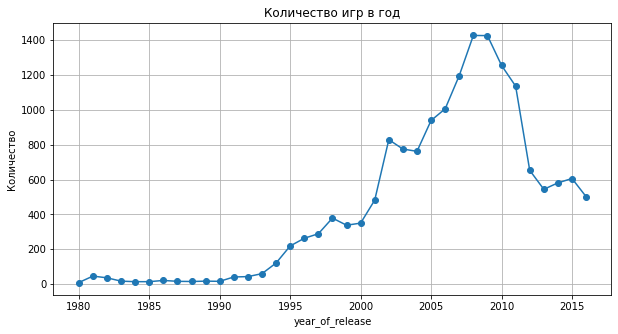

In [15]:
# Посмотрим, сколько игр выпускалось в разные годы.
plt.figure(figsize=(10,5))
plt.title('Количество игр в год')
plt.xlabel('Год')
plt.ylabel('Количество')
games[games['year_of_release'] > 0].groupby('year_of_release')['platform'].agg('count').plot(grid=True, style='o-')
plt.show()

Максимальное число игр выходило c 2005 по 2011гг.

Для планирования рекламной кампании на будущий год нам необходимы только актуальные на данный момент данные. Рассмотрим продажи компьютерных игр на разных платформах по годам и выделим потенциально прибыльные и, соответственно, интересные для нас платформы.

## 3.2. Продажи по платформам. Выбор потенциально прибыльных платформ.

Посмотрим, как менялись продажи по платформам.

In [16]:
# Функция принимает на вход датафрейм `df` и строит по нему график суммарных продаж 
# по списку платформ `platform` по годам с 'year_begin' по 'year_end' включительно 
def year_sales(df, platform, year_begin, year_end, title):
    plt.figure(figsize=(22,9))
    plt.title(title)
    plt.xlabel('Год')
    plt.ylabel('Продажи, млн')
    
    for name in platform: 
        plt.plot(df[(df['year_of_release'] >= year_begin) & (df['year_of_release'] <= year_end) & (df['platform'] == name)]
                 .groupby('year_of_release')['total_sales'].sum(), 'o-', label=name
                )
    
    plt.legend(loc="upper left")
    plt.show()

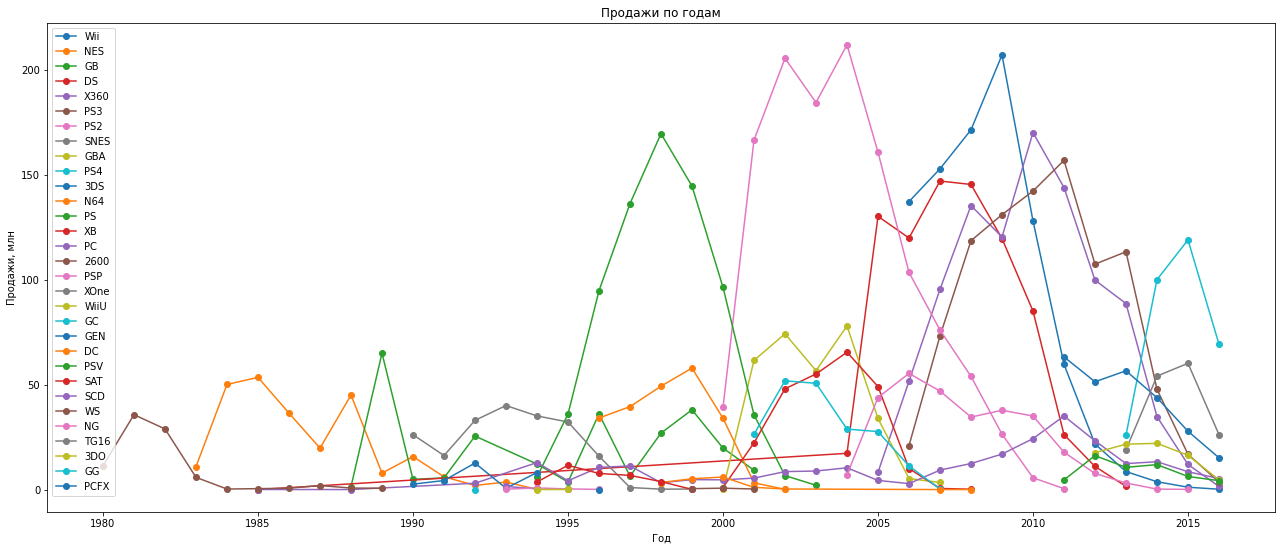

In [17]:
# Посмотрим, как менялись суммарные продажи по всем платформам за все годы:
year_sales(games, games['platform'].unique(), 1980, 2016,'Продажи по годам')


Многовато информации на одном графике. Видно, что с 1996г PS открыла эпоху "больших" продаж. Посмотрим подробнее.

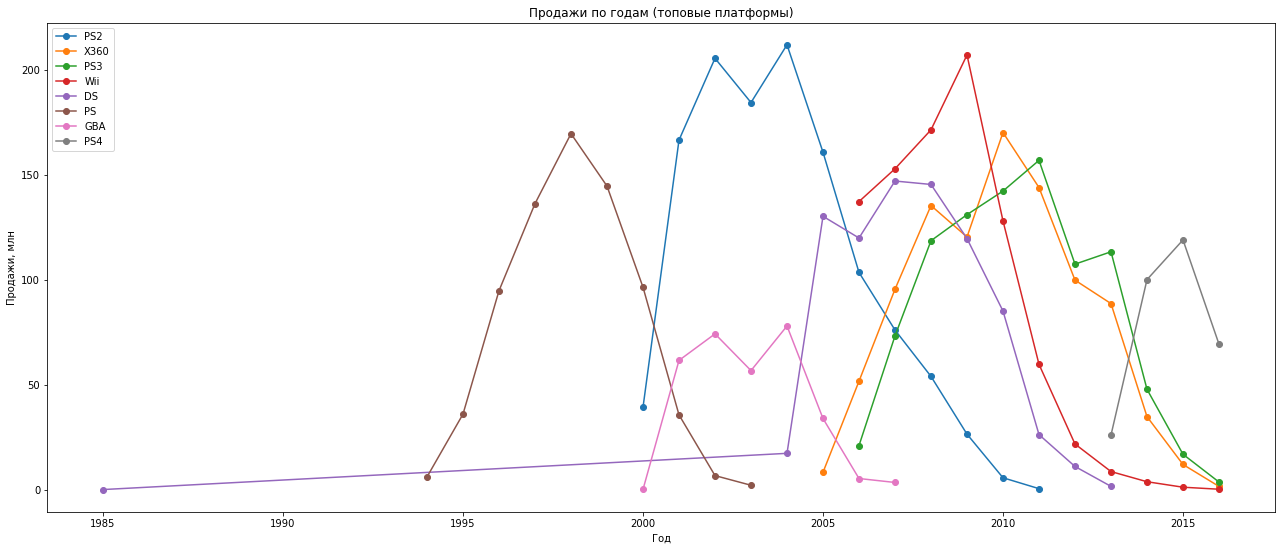

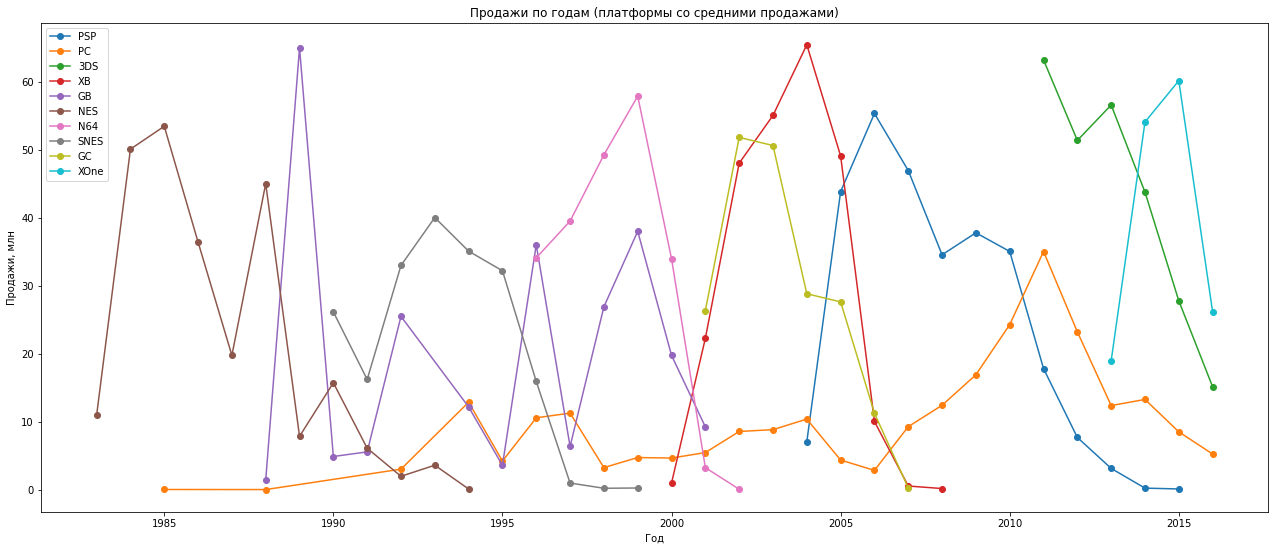

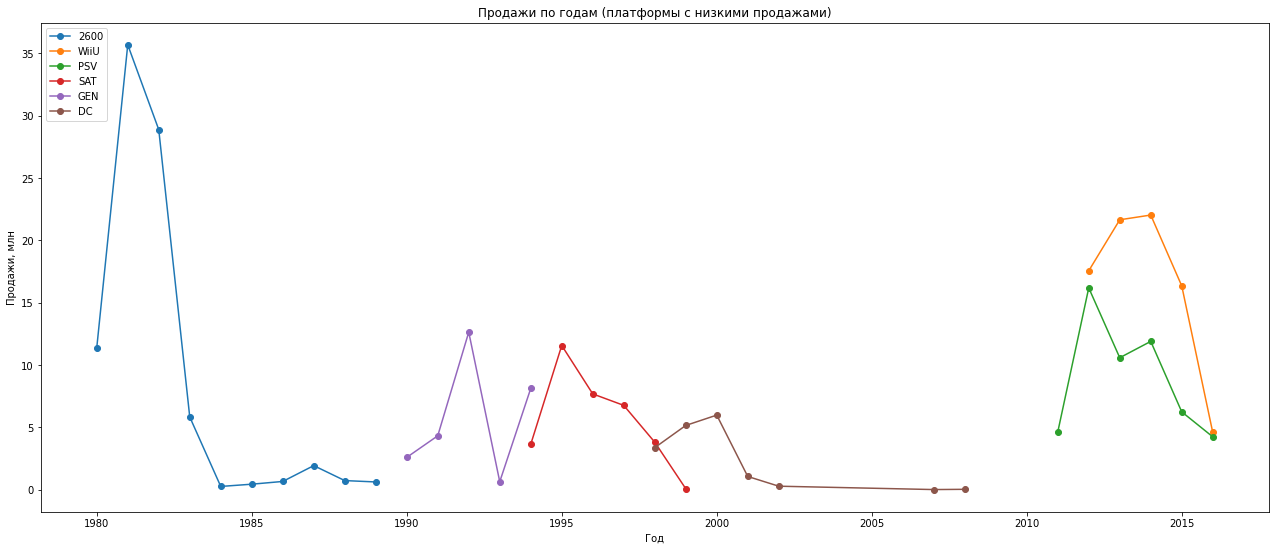

In [18]:
# Отсортируем платформы по суммарным продажам:
top_platforms = games.groupby('platform')['total_sales'].sum().reset_index()
top_platforms.sort_values(by='total_sales', ascending=False, inplace=True)
top_platforms.reset_index(inplace=True)

#display(top_platforms)

# Построим графики по платформам с разными категориями суммарных продаж:
year_sales(games, top_platforms.head(8)['platform'].values, 1980, 2016,'Продажи по годам (топовые платформы)')
year_sales(games, top_platforms.loc[8:17,'platform'].values, 1980, 2016,'Продажи по годам (платформы со средними продажами)')
year_sales(games, top_platforms.loc[18:23,'platform'].values, 1980, 2016,'Продажи по годам (платформы с низкими продажами)')

Тут уже видно, что в среднем платформы существуют 10-13 лет. На верхнем графике заметно, как сменяют друг друга поколения PS: сначала взлёт, потом пик и спуск, сопряжённый с появлением следующей платформы.

Выделим актуальные на данный момент платформы, т.е. платформы стартовавшие относительно недавно и находящиеся в данный момент на подъёме. Судя по графику, это PS4 и XOne, вышедшие в 2013г.

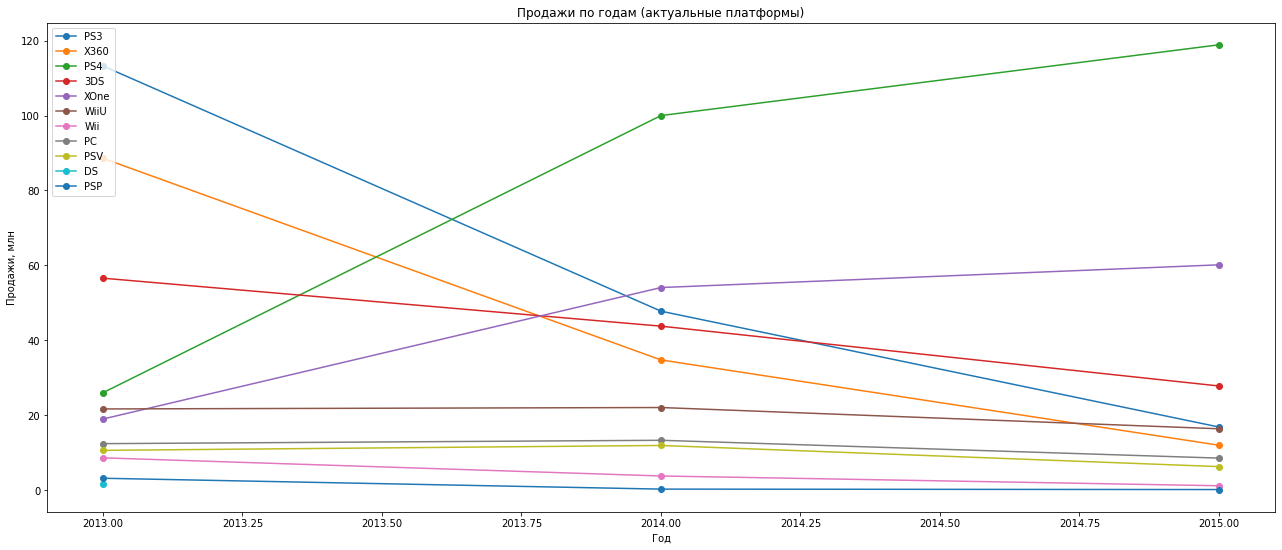

In [19]:
games_relevant = games.query('2013 <= year_of_release <= 2016')

# 2016 год смотреть на графике не будем, т.к. данные по нему не полные
year_sales(games_relevant, games_relevant['platform'].unique(), 2013, 2015,'Продажи по годам (актуальные платформы)')

**Итак, выделим несколько потенциально прибыльных платформ:**

* PS4
* XOne
* 3DS
* WiiU
* PC

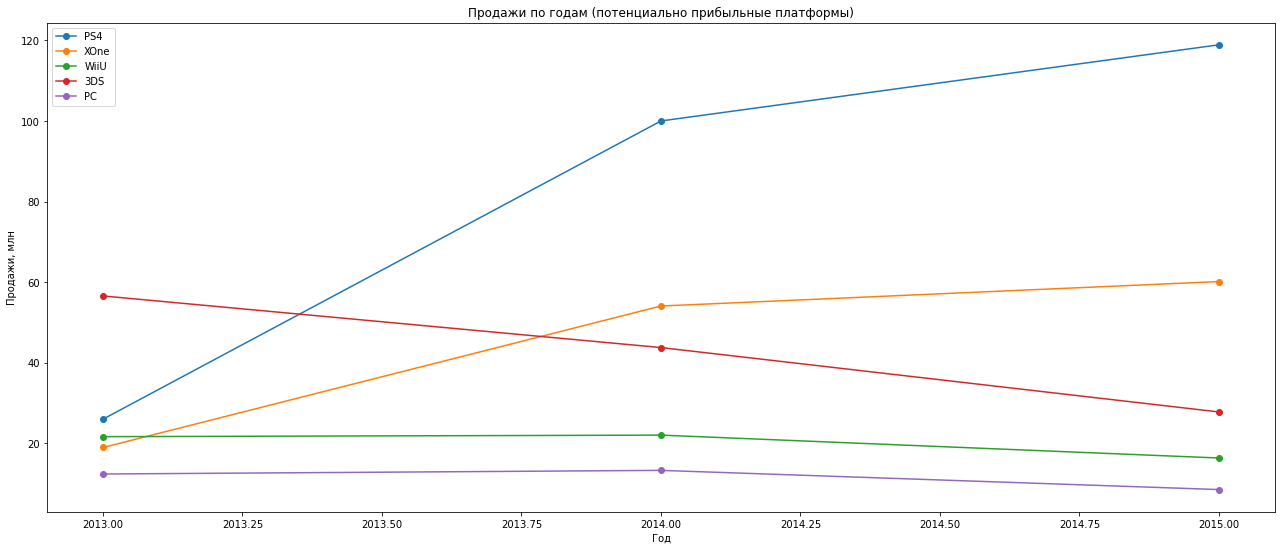

In [20]:
best_platform = ['PS4', 'XOne', 'WiiU', '3DS', 'PC']
year_sales(games_relevant, best_platform, 2013, 2015,'Продажи по годам (потенциально прибыльные платформы)')

## 3.3. Диаграммы размаха продаж по платформам.

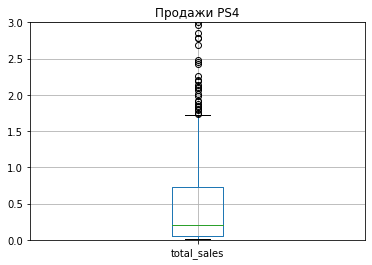

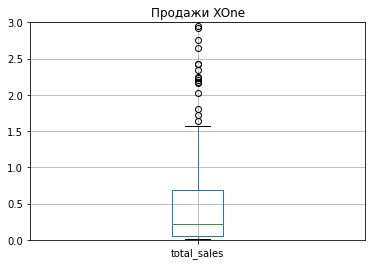

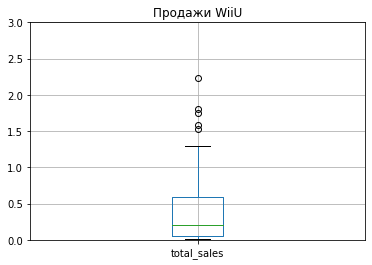

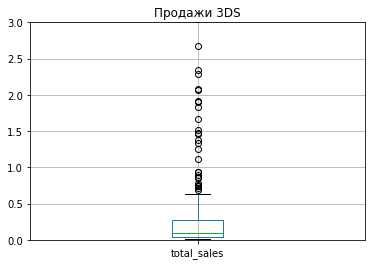

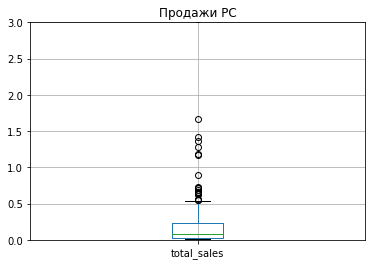

In [21]:
# Рассмотрим диаграммы продаж на потенциальных платформах за последние годы:
for platform in best_platform:
    plt.ylim(0, 3)
    plt.title('Продажи ' + platform)
    games_relevant[games_relevant['platform'] == platform].boxplot(column='total_sales', figsize=(10,5))
    plt.show()

In [22]:
for platform in best_platform:
    print(platform)
    display(games_relevant[games_relevant['platform'] == platform]['total_sales'].describe())

PS4


count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

XOne


count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64

WiiU


count    115.000000
mean       0.562000
std        1.038778
min        0.010000
25%        0.060000
50%        0.200000
75%        0.595000
max        7.090000
Name: total_sales, dtype: float64

3DS


count    303.000000
mean       0.472772
std        1.381347
min        0.010000
25%        0.040000
50%        0.090000
75%        0.280000
max       14.600000
Name: total_sales, dtype: float64

PC


count    189.000000
mean       0.208624
std        0.352304
min        0.010000
25%        0.030000
50%        0.080000
75%        0.230000
max        3.050000
Name: total_sales, dtype: float64

**Вывод.**

* Продаж меньше нуля быть не может, соответственно, распределение скошено вправо.
* Диаграммы расположены в порядке убывания средней суммы продаж на платформе (PS4 -> XOne -> WiiU -> 3DS -> PC).
* При этом на втором месте по количеству вышедших игр (после PS4) находится 3DS, на ней же наблюдается самый большой (не считая PS4) разброс значений, о чём говорит внушительное стандартное отклонение.
* Межквартильный размах для PC меньше всех при большом количестве вышедших игр, т.е. на данной платформе игры собирают меньше денег (продаются меньше и/или дешевле).

## 3.4. Влияние отзывов на продажи.

Проверим, есть ли связь между отзывами и продажами компьютерных игр.

In [23]:
"""
Функция строит график зависимости продаж 'sales' от параметра 'param', 
а также вычисляет для них коэффициент корреляции Пирсона.
Входные параметры:
    df - DataFrame
    sales - столбец с продажами
    param - параметр, по которому проверяется связь с sales
    style - стиль построения графика df.plot()
    alpha - прозрачность линии графика df.plot()
    ylim - минимальное значение оси ординат графика df.plot()
    title - название графика 
"""
def sales_relation(df, sales, param, style, alpha, ylim, title):
    (df
     .pivot_table(index=param, values=sales, aggfunc='sum')
     .plot(grid=True, style=style, title=title, ylim=ylim, figsize=(10, 5), alpha=alpha)
    )
    try:
        print('Коэффициент корреляции Пирсона /', sales, 'и', param, ':', df[sales].corr(df[param]))
    except:
        print('sales_relation: Коэффициент корреляции Пирсона вычислить не удалось')

Коэффициент корреляции Пирсона / total_sales и user_score : -0.020862010596487412
Коэффициент корреляции Пирсона / total_sales и critic_score : 0.39088993631173546


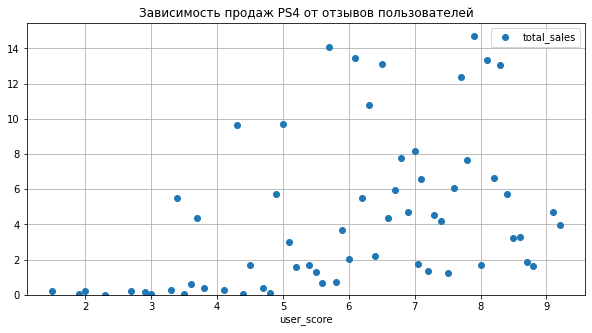

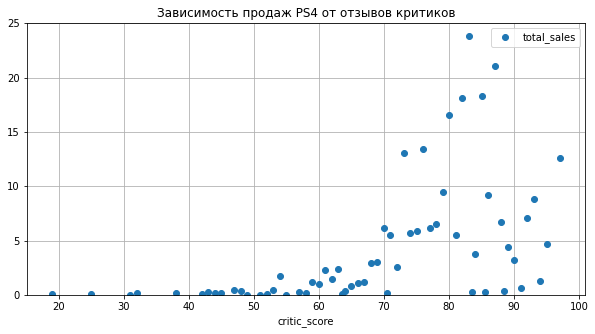

In [24]:
# Рассмотрим зависимость продаж от отзывов пользователей. Возьмём для примера платформу PS4:
sales_relation(games_relevant[games_relevant['platform'] == 'PS4'], 'total_sales', 
               'user_score', 'o', 1, 0, 'Зависимость продаж PS4 от отзывов пользователей'
              )
# Рассмотрим зависимость продаж от отзывов критиков. Так же для PS4:
sales_relation(games_relevant[games_relevant['platform'] == 'PS4'], 'total_sales',  
               'critic_score', 'o', 1, 0, 'Зависимость продаж PS4 от отзывов критиков'
              )

Коэффициент корреляции Пирсона / total_sales и user_score : -0.09647011584254897
Коэффициент корреляции Пирсона / total_sales и critic_score : 0.3743835104785388


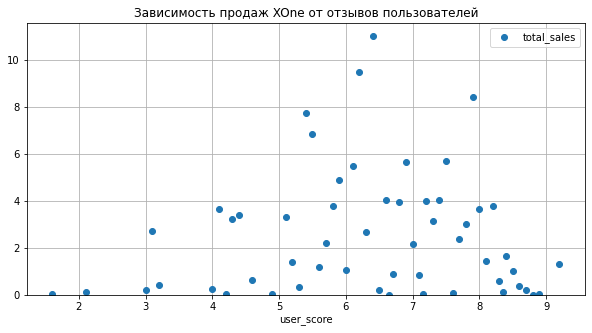

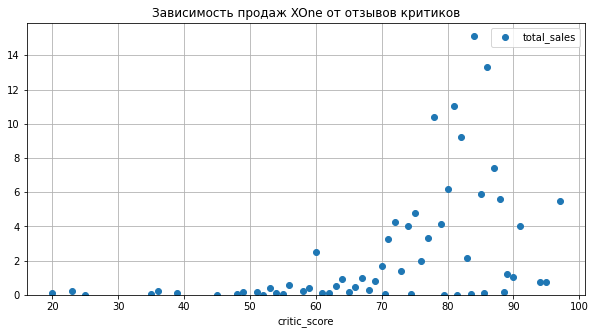

In [25]:
# Посмотрим на другой платформе (XOne):
sales_relation(games_relevant[games_relevant['platform'] == 'XOne'], 'total_sales', 
               'user_score', 'o', 1, 0, 'Зависимость продаж XOne от отзывов пользователей'
              )
sales_relation(games_relevant[games_relevant['platform'] == 'XOne'], 'total_sales', 
               'critic_score', 'o', 1, 0, 'Зависимость продаж XOne от отзывов критиков'
              )


* Связи между отзывами пользователей и продажами нет.
* Связь между отзывами критиков и продажами крайне слаба. Однако, в целом у игр с высоким рейтингом критиков продажи в среднем выше.

## 3.5. Исследование жанров.


Посмотрим на общее распределение игр по жанрам:

In [26]:
games_genre = (games_relevant.groupby('genre')
                .agg(
                    count = ('platform', 'count'),
                        sales_sum = ('total_sales', 'sum'),
                        sales_mean = ('total_sales', 'mean'))
                    .reset_index()
                )
display(games_genre.sort_values('sales_sum', ascending=False))

,genre,count,sales_sum,sales_mean
0,Action,766,321.87,0.420196
8,Shooter,187,232.98,1.245882
10,Sports,214,150.65,0.703972
7,Role-Playing,292,145.89,0.499623
3,Misc,155,62.82,0.405290
4,Platform,74,42.63,0.576081
6,Racing,85,39.89,0.469294
2,Fighting,80,35.31,0.441375
1,Adventure,245,23.64,0.096490
9,Simulation,62,21.76,0.350968


* Больше всего игр выходит в жанре Action, но коэффициент продаж у них средних.
* Самыми прибыльными являются игры жанра Shooter. Их в 4 раза меньше, чем Action, а продажи меньше всего на треть.
* Самыми невостребованные игры - приключения Adventure, головоломки Pazzle и стратегии Strategy.
* Хорошие сборы демонстрируют спортивные Sports и ролевые Role-Playing игры.

# 4. Портрет пользователя по региону  


Рассмотрим топ-5 популярных платформ по регионам:

In [27]:
# Функция выводит пятёрку самых популярных в регионе 'region' платформ по данным 'df' с заголовком 'title'
def best_platforms(df, region, title):
    best_platforms = (df[df[region] > 0].groupby('platform')
                    .agg(
                        count = (region, 'count'),
                        sales_sum = (region, 'sum'),
                        sales_mean = (region, 'mean'))
                    .reset_index()
                )
    print(title, '- популярные платформы:')
    display(best_platforms.sort_values('sales_sum', ascending=False).head(5))
    plt.title('Продажи по платформам, млн. копий')
    plt.xlabel('Платформы')
    plt.ylabel('Продажи')
    df[df[region] > 0].groupby('platform')[region].sum().sort_values(ascending=False).head(5).plot.bar(y='sales_sum')

Северная Америка - популярные платформы:


,platform,count,sales_sum,sales_mean
4,PS4,294,108.74,0.369864
9,XOne,227,93.12,0.410220
8,X360,170,81.66,0.480353
3,PS3,211,63.50,0.300948
0,3DS,119,38.20,0.321008


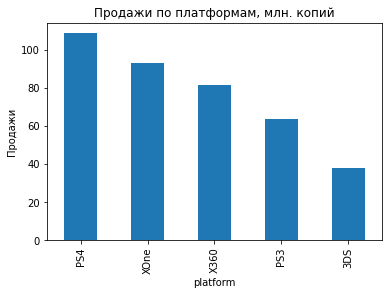

In [28]:
best_platforms(games_relevant, 'na_sales', 'Северная Америка')

Европа - популярные платформы:


,platform,count,sales_sum,sales_mean
4,PS4,290,141.09,0.486517
3,PS3,212,67.81,0.319858
10,XOne,218,51.59,0.236651
9,X360,169,42.52,0.251598
0,3DS,122,30.96,0.253770


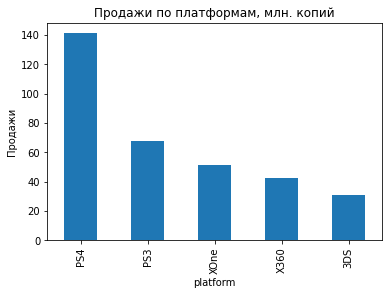

In [29]:
best_platforms(games_relevant, 'eu_sales', 'Европа')

Япония - популярные платформы:


,platform,count,sales_sum,sales_mean
0,3DS,235,67.81,0.288553
1,PS3,236,23.35,0.098941
4,PSV,316,18.59,0.058829
2,PS4,223,15.96,0.071570
6,WiiU,57,10.88,0.190877


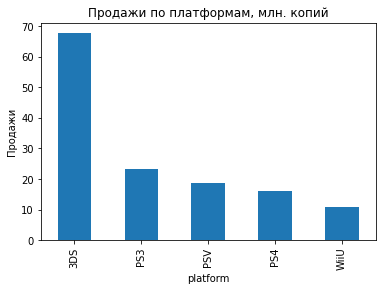

In [30]:
best_platforms(games_relevant, 'jp_sales', 'Япония')


* Самая распространённая по всем регионам платформа - PS4.
* Америка и Европа играют примерно на одних и тех же платформах. Разница только в порядке популярности.
* В Японии предпочитают 3DS от японского производителя Nintendo, а также различные платформы семейства PlayStation (также японского производства).

Америка и Европа играют, как на своих, так и на японских платформах. Япония же предпочитает своего производителя. Вероятно, это связано с тем, что производить игры на английском языке могут как его носители, так и иностранцы. Чего не скажешь про японский язык.


Рассмотрим топ-5 популярных жанров по регионам:

In [31]:
# Функция выводит пятёрку самых популярных в регионе 'region' жанров по данным 'df' с заголовком 'title'
def best_genres(df, region, title):
    best_genres = (df[df[region] > 0].groupby('genre')
                    .agg(
                        count = (region, 'count'),
                        sales_sum = (region, 'sum'),
                        sales_mean = (region, 'mean'))
                    .reset_index()
                )
    print(title, '- популярные жанры:')
    display(best_genres.sort_values('sales_sum', ascending=False).head(5))
    plt.title('Продажи по жанрам, млн. копий')
    plt.xlabel('Жанры')
    plt.ylabel('Продажи')
    df[df[region] > 0].groupby('genre')[region].sum().sort_values(ascending=False).head(5).plot.bar(y='sales_sum')

Северная Америка - популярные жанры:


,genre,count,sales_sum,sales_mean
0,Action,442,126.05,0.285181
8,Shooter,171,109.74,0.641754
10,Sports,143,65.27,0.456434
7,Role-Playing,158,46.40,0.293671
3,Misc,84,27.49,0.327262


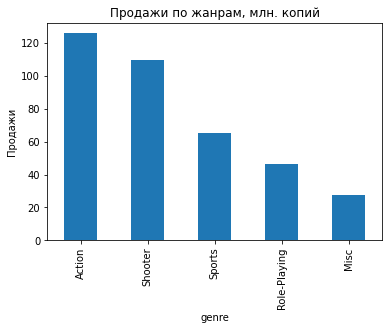

In [32]:
best_genres(games_relevant, 'na_sales', 'Северная Америка')

Европа - популярные жанры:


,genre,count,sales_sum,sales_mean
0,Action,494,118.13,0.239130
8,Shooter,171,87.86,0.513801
10,Sports,169,60.52,0.358107
7,Role-Playing,155,36.97,0.238516
6,Racing,78,20.19,0.258846


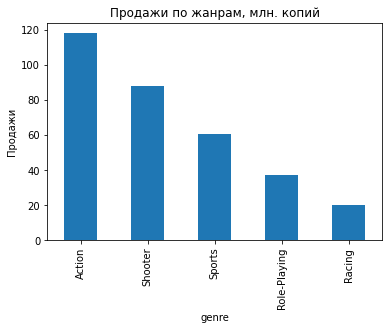

In [33]:
best_genres(games_relevant, 'eu_sales', 'Европа')

Япония - популярные жанры:


,genre,count,sales_sum,sales_mean
7,Role-Playing,236,51.04,0.216271
0,Action,400,40.49,0.101225
3,Misc,90,9.20,0.102222
2,Fighting,59,7.65,0.129661
8,Shooter,69,6.61,0.095797


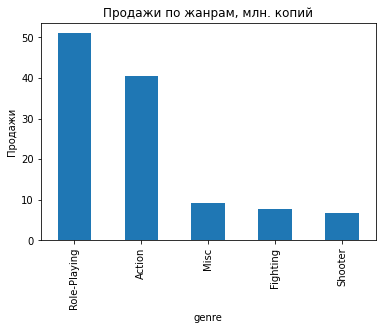

In [34]:
best_genres(games_relevant, 'jp_sales', 'Япония')


* Больше всего игр выходит в жанре Action. При этом их средние продажи нельзя назвать выдающимися.
* Пятёрки популярных жанров по Америке и Европе практически совпадают (разве что Role-Playing и Misc поменялись местами).
* В Японии не так любят стрелялки и спортивные игры. Но предпочитают ролевые жанры, платформеры и приключения.

Посмотрим, влияет ли рейтинг ESRB на продажи в отдельных регионах:

sales_relation: Коэффициент корреляции Пирсона вычислить не удалось
sales_relation: Коэффициент корреляции Пирсона вычислить не удалось
sales_relation: Коэффициент корреляции Пирсона вычислить не удалось


,rating,count,na_sales,eu_sales,jp_sales
0,E,322,86.31,86.48,16.01
1,E10+,262,51.88,44.33,6.24
2,M,420,175.10,156.67,14.87
3,T,376,51.88,43.56,22.84
4,no info,853,72.54,61.19,80.82


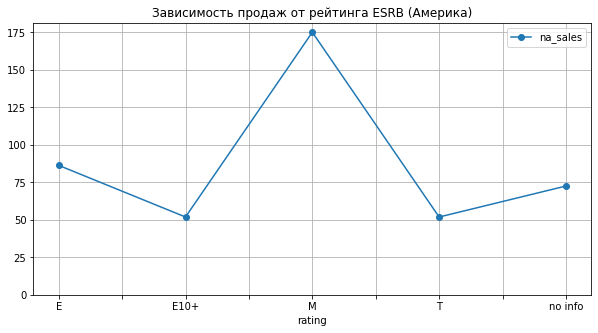

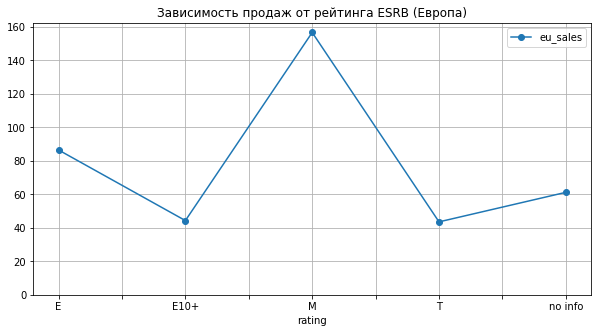

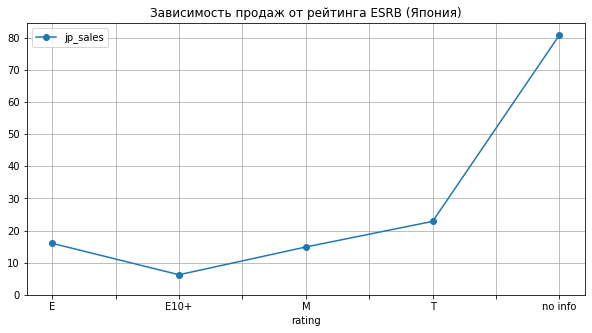

In [35]:
# Северная Америка:
sales_relation(games_relevant, 'na_sales', 'rating', 'o-', 1, 0, 'Зависимость продаж от рейтинга ESRB (Америка)')

# Европа:
sales_relation(games_relevant, 'eu_sales', 'rating', 'o-', 1, 0, 'Зависимость продаж от рейтинга ESRB (Европа)')

# Япония:
sales_relation(games_relevant, 'jp_sales', 'rating', 'o-', 1, 0, 'Зависимость продаж от рейтинга ESRB (Япония)')

rating_group = (games_relevant.groupby('rating')
                    .agg(
                        count = ('platform', 'count'),
                        na_sales = ('na_sales', 'sum'),
                        eu_sales = ('eu_sales', 'sum'),
                        jp_sales = ('jp_sales', 'sum'))
                    .reset_index()
                )
display(rating_group)

* В Северной Америке и Европе лучше продаются игры с рейтингом "M" (Mature - для взрослых).
* Большая часть игр, проданных в Японии, не имеет рейтинга ESRB.

# 5. Проверка гипотез

## 5.1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Предположим, что пользовательские рейтинги платформ Xbox One и PC равны между собой - это наша нулевая гипотеза H0.

Проверим нулевую гипотезу о равенстве средних значений двух выборок:

In [36]:
xone_score = games_relevant[(games_relevant['platform'] == 'XOne') & 
                            ~(games_relevant['user_score'].isna())]['user_score'].values
pc_score = games_relevant[(games_relevant['platform'] == 'PC') & 
                            ~(games_relevant['user_score'].isna())]['user_score'].values

# Для начала сравним дисперсии наших выборок:
xone_disp = np.var(xone_score, ddof=1)
pc_disp = np.var(pc_score, ddof=1)

print('Дисперсия выборки по XOne:', xone_disp)
print('Дисперсия выборки по PC:', pc_disp)

Дисперсия выборки по XOne: 1.8936894
Дисперсия выборки по PC: 3.0521016


Дисперсии пользовательских рейтингов Xbox One и PC значительно отличаются и мы должны учесть это при проверке гипотезы:

In [37]:
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(xone_score, pc_score, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.033333861824149644
Отвергаем нулевую гипотезу



Полученное значение p-value говорит о том, что средниие оценки пользователей по платформам Xbox One и PC **не равны**. Разница между этими значениями есть, и вероятность того, что такую или большую разницу можно получить **случайно** равна 3%. Это, очевидно, слишком большая вероятность, чтобы делать вывод о равенстве средних оценок.

## 5.2. Средние пользовательские рейтинги жанров Action и Sports разные.

Предположим, что пользовательские рейтинги жанров Action и Sports равны между собой - это наша нулевая гипотеза H0.

Проверим нулевую гипотезу о равенстве средних значений двух выборок:

In [38]:
action_score = games_relevant[(games_relevant['genre'] == 'Action') &
                             ~(games_relevant['user_score'].isna())]['user_score'].values
sports_score = games_relevant[(games_relevant['genre'] == 'Sports') &
                             ~(games_relevant['user_score'].isna())]['user_score'].values


# Для начала сравним дисперсии наших выборок:
action_disp = np.var(action_score, ddof=1)
sports_disp = np.var(sports_score, ddof=1)

print('Дисперсия выборки по Action:', action_disp)
print('Дисперсия выборки по Sports:', sports_disp)

Дисперсия выборки по Action: 1.7764802
Дисперсия выборки по Sports: 3.0467257


Дисперсии выборок по жанрам Action и Sports значительно отличаются. Учтём это при проверке гипотезы:

In [39]:
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(action_score, sports_score, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 9.357096708818581e-26
Отвергаем нулевую гипотезу



Полученное значение p-value говорит о том, что средние значения наших выборок **не равны**. И вероятность того, что такой результат мы получили случайно ничтожно мала.

Вероятно, что пользовательские рейтинги жанров Action и Sports различаются. Обратного мы доказать не смогли.

# 6. Общий вывод 

Планируя рукламную кампанию на следующий год, стоит уделить особое внимание играм следующих жанров:

1. Shooter. По ним наблюдаются самые высокие средние продажи в Северной Америке (0.64 млн копий) и Европе (0.51 млн).
2. Sports. Хорошо продаются в Америке (0.46 млн) и Европе (0.36 млн)
Role-Playing. Высокие средние продажи в Японии (0.22 млн), Америке (0.29 млн и Европе (0.24 млн)
3. Жанр Action очень популярен среди производителей компьютерных игр. Однако, средние сборы по играм данного жанра не показывают выдающихся результатов.

Касаемо платформ, имеет смысл сосредоточиться на следующих потенциально прибыльных платформах:

* PS4. Находится на взлёте. Популярна во всех регионах.
* Xbox One. На взлёте. Популярна в Америке и Европе.

При планировании рекламной кампании учитывать отзывы пользователей и критиков смысла нет:

* Связь между отзывами пользователей/критиков и продажами выялена не была.

Стоит учесть, что в Северной Америке и Европе лучше продаются игры с рейтингом ESRB "M" (Mature - для взрослых).